In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [30]:
class NBM:
    def __init__(self, vectorizer='count', laplace=1):
        self.laplace = laplace
        self.vectorizer = vectorizer

    def transform(self, X_train, X_test, method):
        if method != 'count' and method != 'Tfid':
            raise ValueError("Method is not 'count' or 'Tfid'")
        v = CountVectorizer()
        X_train = v.fit_transform(X_train)
        X_test = v.transform(X_test)
        if method == 'Tfid':
            print("Tfid")
            v = TfidfTransformer()
            X_train = v.fit_transform(X_train)
            X_test = v.transform(X_test)
        return X_train, X_test.toarray()

    def fit(self, X, y):
        # Shape        
        m, n = X.shape
        self.classes = np.unique(y)
        k = len(self.classes)
        # fit
        self.likelihoods = np.zeros((k,n))
        self.priors = np.zeros(k)
        for idx, label in enumerate(self.classes):
            X_classed = X[y==label]
            self.likelihoods[idx,:] = self.likelihood_fn(X_classed)
            self.priors[idx] = self.prior_fn(y, label)

    def likelihood_fn(self, X_class):
        dividend  = ((X_class.sum(axis=0)) + self.laplace)
        devider = (np.sum(X_class.sum(axis=0) + self.laplace))
        return  dividend/devider

    def prior_fn(self, y, label):
        return len(y[y==label])/len(y)

    def predict(self, X_test):
        yhat = np.log(self.priors) + X_test @ np.log(self.likelihoods.T)
        yhat = np.argmax(yhat, axis=1)
        return yhat
    


In [26]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()

In [27]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [38]:
model = NBM()

X_train, X_test = model.transform(train.data, test.data, 'Tfid')
y_train = train.target
y_test = test.target

model.fit(X_train, y_train)

yhat = model.predict(X_test)

Tfid


In [39]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, classification_report

n_classes = len(np.unique(y_test))
print(n_classes)

print("=========Average precision score=======")
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
yhat_binarized = label_binarize(yhat, classes=[0, 1, 2, 3])

print(y_test_binarized.shape)
print(yhat_binarized.shape)

for i in range(n_classes):
    class_score = average_precision_score(y_test_binarized[:, i], yhat_binarized[:, i])
    print(f"Class {i} score: ", class_score)
    
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))

4
=========Average precision score=======
(1432, 4)
(1432, 4)
Class 0 score:  0.888341920518241
Class 1 score:  0.8744630809734135
Class 2 score:  0.6122064043881043
Class 3 score:  0.332994836297269
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.97      0.88      0.92       389
           1       0.92      0.92      0.92       394
           2       0.62      0.98      0.76       398
           3       1.00      0.19      0.32       251

    accuracy                           0.80      1432
   macro avg       0.88      0.75      0.73      1432
weighted avg       0.86      0.80      0.77      1432



Text(32.99999999999999, 0.5, 'predicted')

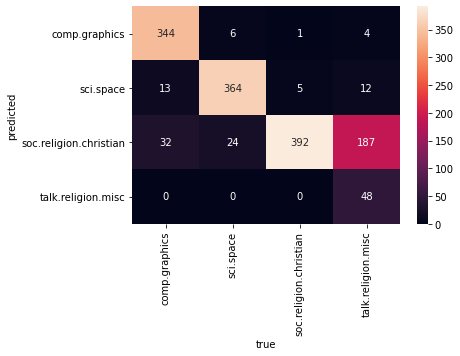

In [40]:
from sklearn.metrics import confusion_matrix

#use confusion matrix
mat = confusion_matrix(y_test, yhat)

import seaborn as sns
sns.heatmap(mat.T, annot=True, fmt="d",
           xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true')
plt.ylabel('predicted')